In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import pandas as pd
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

In [4]:
df_station = pd.read_csv('../data/station_vis_all_estimated.csv')
## 总结df_station
# print(df_station.describe())
print(df_station.info())
print(df_station.head())
print(df_station.tail())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   code        1330 non-null   object 
 1   name        1330 non-null   object 
 2   city        1330 non-null   object 
 3   county      1330 non-null   object 
 4   lon         1330 non-null   float64
 5   lat         1330 non-null   float64
 6   altitude    1330 non-null   float64
 7   rh          1330 non-null   float64
 8   vis         1330 non-null   float64
 9   vis_rh      1243 non-null   float64
 10  vis_dis     1243 non-null   float64
 11  is_vis_est  1330 non-null   int64  
dtypes: float64(7), int64(1), object(4)
memory usage: 124.8+ KB
None
    code       name city   county      lon     lat  altitude    rh     vis  \
0  57988  乐昌国家基本气象站   韶关      乐昌市  113.345  25.110     143.2  96.0   800.0   
1  57989  仁化国家基本气象站   韶关      仁化县  113.763  25.059     112.7  96.0   200.0   
2  57996  南雄国家基准

In [5]:
ds_dem = xr.open_dataset(r'h:\data\DEM\merged_dem_data.nc')
print(ds_dem)

<xarray.Dataset> Size: 5MB
Dimensions:    (lat: 612, lon: 1020)
Coordinates:
  * lat        (lat) float64 5kB 20.0 20.01 20.02 20.03 ... 25.99 26.0 26.01
  * lon        (lon) float64 8kB 109.0 109.0 109.0 109.0 ... 119.0 119.0 119.0
Data variables:
    elevation  (lat, lon) float64 5MB ...
Attributes:
    title:                          Optimized Merged DEM data
    description:                    Combined from 34 individual DEM tiles wit...
    creation_date:                  2025-08-04T16:37:56
    source_files_count:             34
    processing_info:                Merged using optimized algorithm with bou...
    boundary_optimization_enabled:  true


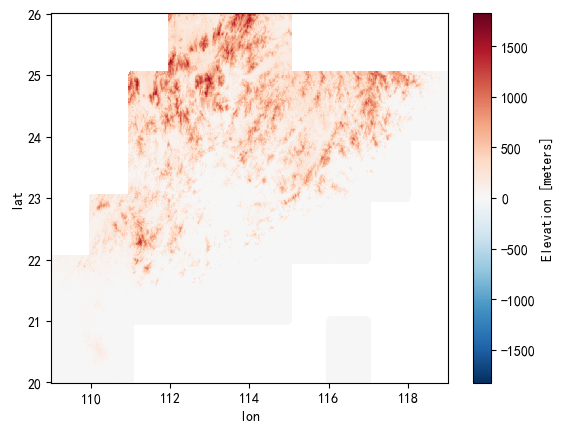

In [8]:
ds_dem['elevation'].plot()
elevation = ds_dem['elevation']

In [ ]:
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors

def anisotropic_idw_interpolation(df_station, ds_dem, beta=10, p=2, n_neighbors=6):
    """
    各向异性反距离权重法插值
    
    参数:
    - df_station: 站点数据，包含lon, lat, vis, altitude字段
    - ds_dem: DEM数据集，用于获取插值网格和海拔信息
    - beta: 垂直方向权重放大因子，默认10
    - p: 权重幂次，控制衰减速度，默认2
    - n_neighbors: 最近邻居数，默认6
    
    返回:
    - vis_interpolated: 插值后的能见度xarray.DataArray
    """
    
    # 获取DEM的经纬度网格
    lon_grid = ds_dem.lon.values
    lat_grid = ds_dem.lat.values
    elevation_data = ds_dem.elevation.values
    
    # 创建插值目标网格点
    lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
    
    # 将经纬度转换为欧氏距离的近似换算 (度转米的粗略换算)
    # 在这个区域，1度经度约等于111km，1度纬度约等于111km
    km_per_degree_lon = 111.0 * np.cos(np.radians(np.mean(lat_grid)))
    km_per_degree_lat = 111.0
    
    # 站点数据预处理
    station_lon = df_station['lon'].values
    station_lat = df_station['lat'].values  
    station_vis = df_station['vis'].values
    station_alt = df_station['altitude'].values
    
    # 将站点坐标转换为欧氏坐标 (单位：km)
    station_x = station_lon * km_per_degree_lon
    station_y = station_lat * km_per_degree_lat
    station_z = station_alt / 1000.0  # 转换为km
    
    # 构建站点的3D坐标数组
    station_coords = np.column_stack([station_x, station_y, station_z])
    
    # 初始化插值结果数组
    vis_result = np.full(lon_mess.shape, np.nan)
    
    # 为快速搜索最近邻居，使用KDTree
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree').fit(station_coords)
    
    print(f"开始插值，网格大小: {vis_result.shape}")
    
    # 对每个网格点进行插值
    for i in range(len(lat_grid)):
        if i % 50 == 0:  # 每50行输出一次进度
            print(f"处理进度: {i}/{len(lat_grid)} ({i/len(lat_grid)*100:.1f}%)")
            
        for j in range(len(lon_grid)):
            # 当前网格点的坐标
            grid_lon = lon_grid[j]
            grid_lat = lat_grid[i]
            grid_alt = elevation_data[i, j]
            
            # 跳过无效的DEM高程值
            if np.isnan(grid_alt):
                continue
                
            # 转换为欧氏坐标
            grid_x = grid_lon * km_per_degree_lon
            grid_y = grid_lat * km_per_degree_lat
            grid_z = grid_alt / 1000.0  # 转换为km
            
            grid_point = np.array([[grid_x, grid_y, grid_z]])
            
            # 找到最近的n_neighbors个站点
            distances, indices = nbrs.kneighbors(grid_point)
            distances = distances[0]
            indices = indices[0]
            
            # 计算各向异性距离
            aniso_distances = []
            for idx in indices:
                dx = station_x[idx] - grid_x
                dy = station_y[idx] - grid_y  
                dz = station_z[idx] - grid_z
                
                # 各向异性距离公式：考虑垂直方向放大因子beta
                aniso_dist = np.sqrt(dx**2 + dy**2 + (beta * dz)**2)
                aniso_distances.append(aniso_dist)
            
            aniso_distances = np.array(aniso_distances)
            
            # 避免除零错误，如果距离太小则设为最小值
            aniso_distances = np.maximum(aniso_distances, 1e-10)
            
            # 计算权重 w_i = 1/d_i^p
            weights = 1.0 / (aniso_distances ** p)
            
            # 获取对应站点的能见度值
            vis_values = station_vis[indices]
            
            # 加权平均插值
            vis_interpolated = np.sum(weights * vis_values) / np.sum(weights)
            vis_result[i, j] = vis_interpolated
    
    print("插值完成!")
    
    # 创建xarray.DataArray
    vis_da = xr.DataArray(
        vis_result,
        coords={'lat': lat_grid, 'lon': lon_grid},
        dims=['lat', 'lon'],
        name='visibility',
        attrs={
            'long_name': '能见度插值结果',
            'units': 'm',
            'method': 'Anisotropic IDW',
            'beta': beta,
            'power': p,
            'n_neighbors': n_neighbors,
            'description': f'使用各向异性反距离权重法插值，垂直缩放因子={beta}，权重幂次={p}，邻居数={n_neighbors}'
        }
    )
    
    return vis_da

# 执行插值
print("开始各向异性IDW插值...")
vis_interpolated = anisotropic_idw_interpolation(df_station, ds_dem, beta=10, p=2, n_neighbors=6)
print(f"插值结果形状: {vis_interpolated.shape}")
print(f"插值结果统计:\n{vis_interpolated.describe()}")